In [1]:
import numpy as np
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS

import cmocean as oc

import smplotlib
import matplotlib.pyplot as plt

In [2]:
file_path = 'HOPS355_Continuum.fits'
hdul = fits.open(file_path)
data = hdul[0].data
header = hdul[0].header
hdul.close()

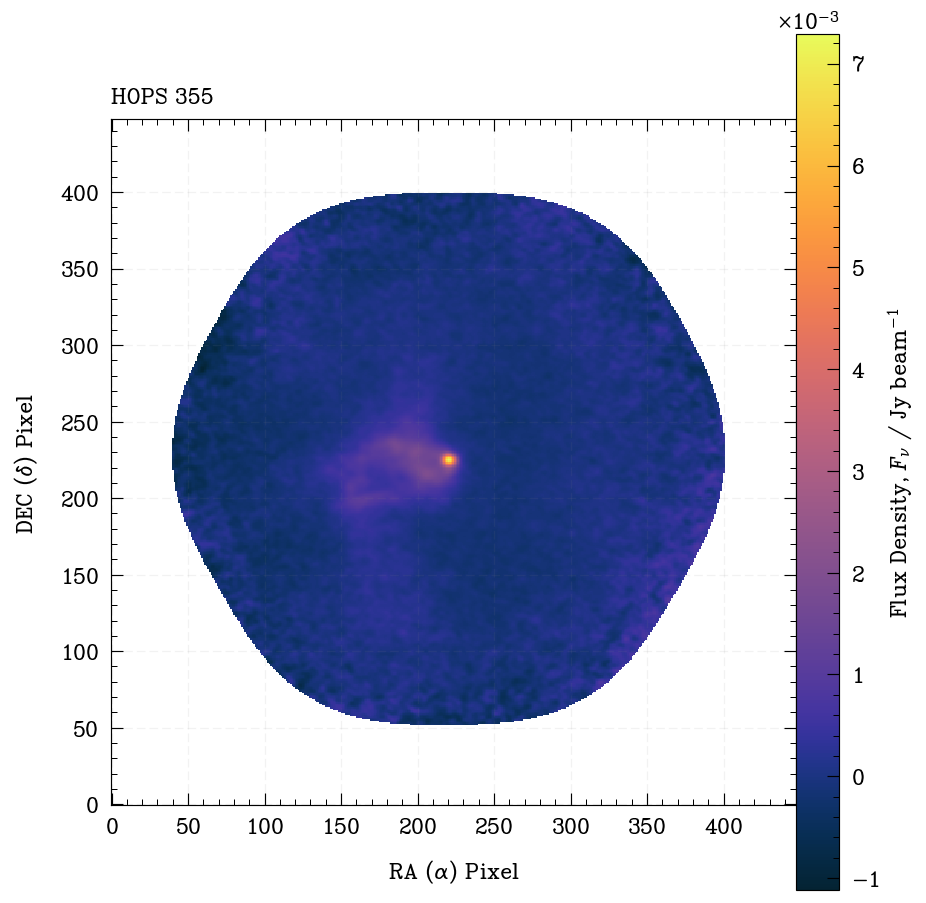

In [3]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.grid(alpha = 0.1)
ax.set_title(r'HOPS 355', fontsize = 15, loc = 'left')
p = plt.imshow(data, cmap = oc.cm.thermal, origin = 'lower')
plt.colorbar(p, label = r'Flux Density, $F_\nu$ / Jy beam$^{-1}$', pad = 0)
ax.set_xlabel(r'RA ($\alpha$) Pixel', fontsize = 15, labelpad = 12)
ax.set_ylabel(r'DEC ($\delta$) Pixel', fontsize = 15, labelpad = 12)

plt.tight_layout()
plt.savefig('Q07_HOPS355.pdf', dpi = 800)

In [4]:
distance_pc = 416
distance_cm = distance_pc * 3.086e18
frequency = 232.6e9
temperature = 10 # dust
dust_opacity = 0.02
gas_to_dust_ratio = 130

In [5]:
beam_major = header['BMAJ'] * 3600 # deg to arcsec
beam_minor = header['BMIN'] * 3600
beam_area = np.pi * (beam_major / 2) * (beam_minor / 2)
pixel_scale = abs(header['CDELT1']) * 3600
pixel_area = pixel_scale ** 2
beam_correction = pixel_area / beam_area  # Jy/beam to Jy/pixel

wcs = WCS(header)
image_center = (data.shape[1] // 2, data.shape[0] // 2)
angular_radius = (2500 / (distance_pc * 206265))

y, x = np.indices(data.shape)
ra, dec = wcs.all_pix2world(x, y, 0)
center_ra, center_dec = wcs.all_pix2world(image_center[1], image_center[0], 0)
angular_distance = np.sqrt((ra - center_ra)**2 + (dec - center_dec)**2)
mask = angular_distance <= angular_radius

bunit = header.get('BUNIT', '').strip()
if 'Jy/beam' in bunit:
    flux_correction = beam_correction
else:
    flux_correction = 1.0

In this case, we estimate the total mass (gas plus dust) contained within a molecular cloud core observed at a frequency of 232.6 GHz. We assume a source distance of 416 parsecs, corresponding to a linear distance of $d = 416 \times 3.086 \times 10^{18}$ cm. The dust temperature is assumed to be $10~K$, and the dust opacity at the observed frequency is set to $\kappa_\nu = 0.02\ \mathrm{cm}^2\ \mathrm{g}^{-1}$, appropriate for cold, dense environments (Furlan et al., 2016, ApJS, 224, 5). A gas-to-dust mass ratio of 130 is also adopted.

The telescope’s beam size is retrieved from the FITS header, with the major and minor axes given in degrees and converted to arcseconds. For instance, if $\text{BMAJ} = 0.001$ degrees, this yields $0.001 \times 3600 = 3.6{\prime}{\prime}$. The beam area is then computed assuming a Gaussian profile as $A_{\text{beam}} = \pi ( \text{major} / 2 ) ( \text{minor} / 2 )$. The pixel scale is similarly determined from the WCS information, with each pixel subtending an area $\text{pixel\_area} = (\text{pixel\_scale})^2$ in arcsec-squared.

A correction factor is calculated to convert Jy/beam to Jy/pixel if necessary (that one final ~if~), given by the ratio of the pixel area to the beam area. Using the WCS solution, we determine the central pixel coordinates and convert them to RA/Dec. The angular radius corresponding to a physical scale of 2500 AU is calculated using 

$$
\theta = \frac{2500\ \mathrm{AU}}{416\ \mathrm{pc} \times 206265\ \mathrm{AU/arcsec}} \approx 0.029{\prime}{\prime}.
$$

We constructed a two-dimensional mask, selecting all pixels within this angular distance from the centre.

We then integrate the total flux inside the masked region. If the FITS file has flux units in Jy/beam, the fluxes are corrected by the beam-to-pixel factor; otherwise, they are summed directly. The integrated flux is converted from Jy to cgs units by multiplying by $10^{-23}$.

Next, we calculate the Planck function at 232.6 GHz and $10~K$ as

$$
B_\nu(T) = \frac{2h\nu^3}{c^2} \frac{1}{\exp\left( \frac{h\nu}{kT} \right) - 1},
$$

where h is Planck’s constant, c is the speed of light, and k is Boltzmann’s constant.


The dust mass is then derived assuming optically thin emission, using the standard relation

$$
M_\mathrm{dust} = \frac{F_\nu d^2}{\kappa_\nu B_\nu(T)}.
$$

In our case, $F_\nu$ is the integrated flux in erg/s/cm2/Hz, $d$ is the distance in cm, $\kappa_\nu$ is the dust opacity, and $B_\nu(T)$ is the Planck function evaluated at the dust temperature as previously mentioned.

Finally, the total mass is obtained by multiplying the dust mass by the gas-to-dust ratio of 130.

In [6]:
total_flux = np.nansum(data[mask]) * flux_correction  # Convert to Jy
total_flux_cgs = total_flux * 1e-23
B_nu = (2 * 6.626e-27 * frequency**3 / 3e10**2) / (np.exp((6.626e-27 * frequency) / (1.38e-16 * temperature)) - 1)
M_dust = (total_flux_cgs * distance_cm**2) / (dust_opacity * B_nu) * u.g
M_total = M_dust * gas_to_dust_ratio

M_total.to(u.Msun)

<Quantity 0.07043439 solMass>

**IMPORTANT NOTE: IF WE INCREASE THE CONSIDERED AREA WE OBTAIN THAT THE ENVELOPE MASS IS ABOUT $0.87~M_\odot$** (I guess this value is more correct, by assuming a larger area; considering just 2500 AU we just capture the "core" region)

In [7]:
beam_major = header['BMAJ'] * 3600 # deg to arcsec
beam_minor = header['BMIN'] * 3600
beam_area = np.pi * (beam_major / 2) * (beam_minor / 2)
pixel_scale = abs(header['CDELT1']) * 3600
pixel_area = pixel_scale ** 2
beam_correction = pixel_area / beam_area  # Jy/beam to Jy/pixel

wcs = WCS(header)
image_center = (data.shape[1] // 2, data.shape[0] // 2)
angular_radius = (9000 / (distance_pc * 206265))

y, x = np.indices(data.shape)
ra, dec = wcs.all_pix2world(x, y, 0)
center_ra, center_dec = wcs.all_pix2world(image_center[1], image_center[0], 0)
angular_distance = np.sqrt((ra - center_ra)**2 + (dec - center_dec)**2)
mask = angular_distance <= angular_radius

bunit = header.get('BUNIT', '').strip()
if 'Jy/beam' in bunit:
    flux_correction = beam_correction
else:
    flux_correction = 1.0


total_flux = np.nansum(data[mask]) * flux_correction  # Convert to Jy
total_flux_cgs = total_flux * 1e-23
B_nu = (2 * 6.626e-27 * frequency**3 / 3e10**2) / (np.exp((6.626e-27 * frequency) / (1.38e-16 * temperature)) - 1)
M_dust = (total_flux_cgs * distance_cm**2) / (dust_opacity * B_nu) * u.g
M_total = M_dust * gas_to_dust_ratio

M_total.to(u.Msun)

<Quantity 0.87778085 solMass>